In [11]:
import numpy as np
from scipy.integrate import RK45,solve_ivp
from ODE_potentials import VanDerPolePotential,LotkiVolterraPotential
from ODE_samplers import MALA_ODE,ULA_ODE,grad_ascent_ODE,run_eval_test,set_function
from multiprocessing import Pool
import multiprocessing
from zv_cv import Eval_ZVCV

from baselines import construct_ESVM_kernel
from optimize import optimize_parallel_new
from utils import *

Parameters for van-der-Pole and Lotki-Volterra examples: 

In [12]:
typ = 'LV' #'LV' for Lotki-Volterra, 'VdP' for Van-der-Pole
method = {"sampler":"MALA"} #switch between ULA and MALA
f_type = "sum_comps"

if typ == 'VdP':
    #true parameter value
    theta_star = 1.0
    #initial coordiante and speed
    y0 = np.array([0.0,2.0],dtype=float)
    #error of measurements
    sigma = 0.5
    #prior variance
    sigma_prior = 0.5
elif typ == 'LV':
    theta_star = np.array([0.6,0.025,0.8,0.025],dtype = float)
    #initial number of victims and predators
    y0 = np.array([30.0,4.0],dtype=float)
    #setting prior parameters
    sigma_prior = np.array([0.5,0.05,0.5,0.05],dtype = float)
    mu_prior = np.array([1.0,0.05,1.0,0.05],dtype=float)
    #measurements error
    sigma = np.array([0.25,0.25])

Timestaps

In [13]:
#initial and last time moments
t0 = 0
t_bound = 10
#moments of observations
t_moments = np.arange(t_bound+1)

Creating potentials

In [14]:
if typ == 'VdP':
    Cur_pot = VanDerPolePotential(sigma,sigma_prior,t_moments,theta_star,y0,t0,t_bound)
elif typ == 'LV':
    Cur_pot = LotkiVolterraPotential(sigma,mu_prior,sigma_prior,t_moments,theta_star,y0,t0,t_bound)

system solved
[[ 37.52358801   5.44451059]
 [ 49.31015054   4.44056815]
 [ 68.02780239   7.49382876]
 [ 96.31994597  69.0224216 ]
 [ 33.96485552 119.57915384]
 [ 11.19476367  55.29111344]
 [  7.28510513  25.46629586]
 [  3.95843583  11.12542133]
 [ 12.06748946   3.71380176]
 [ 12.38341447   6.01556616]
 [ 18.28774199   3.71351383]]


Sampling (currently with MALA)

In [15]:
r_seed = 666
#burn-in period
N_burn = 1*10**3
#Train size
N_train = 1*10**4
#Test size
N_test = 1*10**4
#number of test trajectories
n_traj_test = 100
if typ == 'VdP':
    #dimension
    d = 1
    #step size
    step = 1e-3
elif typ == 'LV':
    #dimension
    d = 4
    #step size
    step = 5e-6

### Construct kernels and sample

In [16]:
# Construct kernel
#W_train_spec = construct_ESVM_kernel(N_train)
#W_test_spec = construct_ESVM_kernel(N_test)

In [17]:
if typ == 'VdP':
    params_prior = {"sigma":sigma_prior}
elif typ == 'LV':
    params_prior = {"mu":mu_prior,"sigma":sigma_prior}

### Compute starting point (maximum likelihood)

In [18]:
N_steps_ascent = 1000
traj,traj_grad = grad_ascent_ODE(1453,Cur_pot,step,params_prior,N_steps_ascent,d,typ)
theta_mle = traj[-1,:]
print("mle for parameters: ",theta_mle)
Cur_pot.set_mle(theta_mle)

mle for parameters:  [0.64676518 0.02390862 0.81163324 0.0246156 ]


In [19]:
print(traj_grad[-10:,:])

[[-0.00323895 -0.02115902  0.00268793  0.01705119]
 [-0.00320707 -0.0209508   0.00266156  0.01688336]
 [-0.0031755  -0.02074464  0.00263544  0.01671719]
 [-0.00314424 -0.02054052  0.00260958  0.01655266]
 [-0.00311329 -0.02033841  0.00258398  0.01638976]
 [-0.00308265 -0.0201383   0.00255863  0.01622846]
 [-0.00305231 -0.01994016  0.00253353  0.01606877]
 [-0.00302227 -0.01974398  0.00250867  0.01591064]
 [-0.00299253 -0.01954974  0.00248406  0.01575408]
 [-0.00296308 -0.01935742  0.00245968  0.01559907]]


### Setting function 

In [20]:
inds_arr = np.array([0])
params = {"ind":0}
t_moments = None
r_seed = 777
n_traj = 24
traj = []
traj_grad = []
#genertae data
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(MALA_ODE, [(r_seed+i,Cur_pot, step, params_prior, N_burn, N_train, d, typ) for i in range (n_traj)])
trav.close()
for i in range(len(res)):
    traj.append(res[i][0])
    traj_grad.append(res[i][1])
    print("accepted = ",res[i][2])
traj = np.asarray(traj)
traj_grad = np.asarray(traj_grad)
traj_grad = (-1)*traj_grad

accepted =  7902
accepted =  8030
accepted =  7910
accepted =  7939
accepted =  7864
accepted =  7995
accepted =  8021
accepted =  7962
accepted =  7812
accepted =  7888
accepted =  7964
accepted =  8039
accepted =  7978
accepted =  8012
accepted =  7869
accepted =  7865
accepted =  7864
accepted =  7849
accepted =  7999
accepted =  7841
accepted =  8040
accepted =  7937
accepted =  8000
accepted =  8015


### Apply control variates

In [175]:
#f_type = "sum"
f_type = "sum_comps"
params = {"ind":3}
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Eval_ZVCV, [(traj[i,:,:],traj_grad[i,:,:],f_type,params) for i in range (n_traj)])
trav.close()

(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)


In [176]:
print(f_type)

sum_comps


In [177]:
res_arr = np.asarray(res)
print(res_arr.shape)

(24, 5)


### Plotting the results

In [178]:
title = ""
labels = ['Vanilla\n MALA', 'MALA \nwith ZV-1', 'MALA \nwith CV-1']

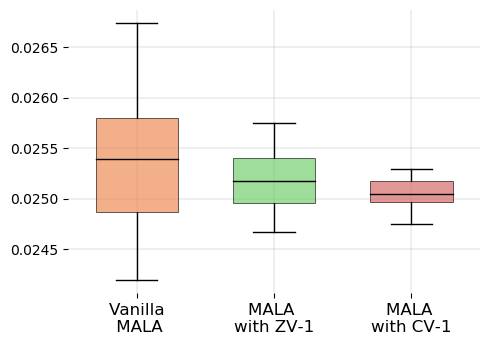

In [179]:
data = [res_arr[:,0],res_arr[:,1],res_arr[:,3]] 
boxplot_ind(data, title, labels)

In [180]:
title = ""
labels = ['MALA \nwith ZV-1', 'MALA \nwith CV-1']

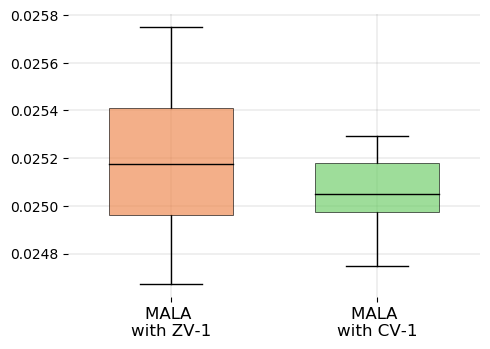

In [181]:
data = [res_arr[:,1],res_arr[:,3]] 
boxplot_ind(data, title, labels)

In [182]:
title = ""
labels = ['Vanilla\n MALA', 'MALA \nwith ZV-2', 'MALA \nwith CV-2']

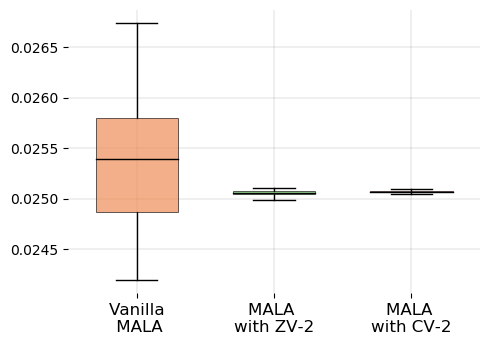

In [183]:
data = [res_arr[:,0],res_arr[:,2],res_arr[:,4]] 
boxplot_ind(data, title, labels)

In [184]:
title = ""
labels = ['MALA \nwith ZV-2', 'MALA \nwith CV-2']

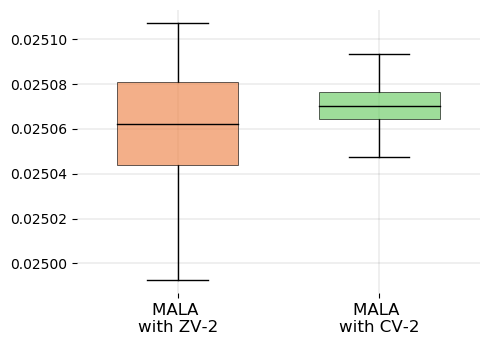

In [185]:
data = [res_arr[:,2],res_arr[:,4]] 
boxplot_ind(data, title, labels)